# **Mammogram Image Analysis Project**

In [ ]:
from google.colab import drive
import cv2
import os
import numpy as np
from skimage.transform import resize
from skimage.filters import median, threshold_otsu
from skimage.morphology import binary_closing, binary_opening, binary_erosion, binary_dilation
from skimage.measure import find_contours
import pandas as pd
from skimage.io import imread
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
pip install tensorflow

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# **preprocess_images on a single image as example**


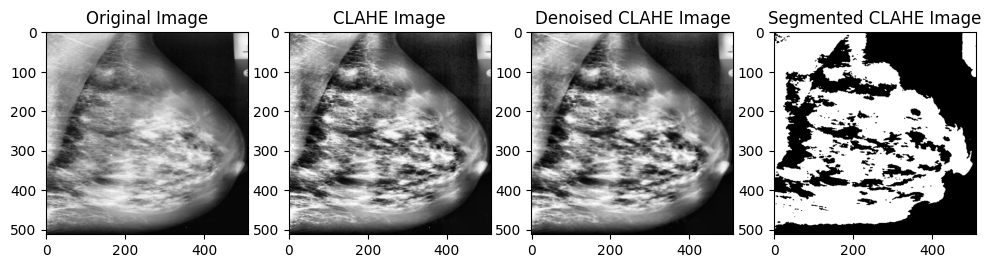

<ipython-input-6-497346c3dc21>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  contour = np.array(contour, dtype=np.int)


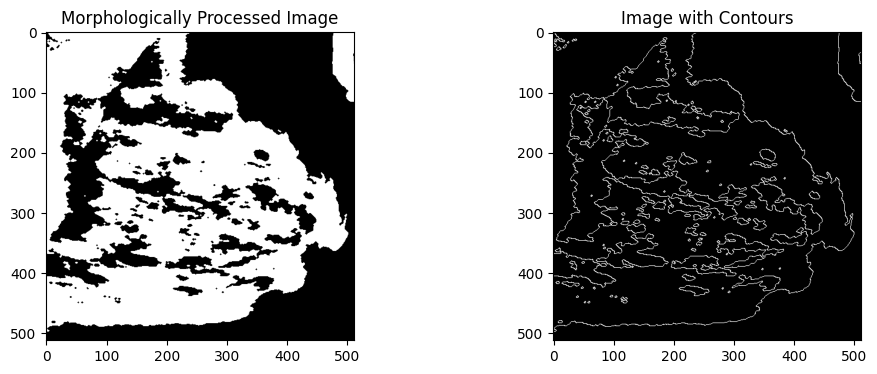

array([[False,  True, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# Function to convert image to grayscale
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Function to apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
def apply_clahe(gray_img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray_img)

# Function to apply median filtering for noise reduction
def apply_median_filter(img):
    kernel_size = 3
    median = cv2.medianBlur(img, kernel_size)
    return median

# Function to apply segmentation (thresholding)
def apply_thresholding(img):
    threshold_value = threshold_otsu(img)
    return img > threshold_value

# Function to apply morphological operations
def apply_morphological_operations(segmented_img):
    closed_img = binary_closing(segmented_img)
    opened_img = binary_opening(closed_img)
    eroded_img = binary_erosion(opened_img)
    dilated_img = binary_dilation(eroded_img)
    return dilated_img

# Function to find and draw contours
def find_and_draw_contours(img):
    contours = find_contours(img, 0.8)
    contour_img = np.zeros_like(img)
    for contour in contours:
        contour = np.array(contour, dtype=np.int)
        contour_img[contour[:, 0], contour[:, 1]] = 1
    return contour_img

# Function to preprocess a single image
def preprocess_single_image_and_display(img_path, save_path=None, target_size=(256, 256)):
    img = cv2.imread(img_path)

    # Convert image to grayscale
    gray_img = convert_to_gray(img)

    # Plot original image
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    # Apply CLAHE
    clahe_img = apply_clahe(gray_img)

    # Plot CLAHE-enhanced image
    plt.subplot(1, 4, 2)
    plt.imshow(clahe_img, cmap='gray')
    plt.title('CLAHE Image')

    # Apply median filtering for noise reduction
    denoised_clahe_img = apply_median_filter(clahe_img)

    # Plot denoised CLAHE-enhanced image
    plt.subplot(1, 4, 3)
    plt.imshow(denoised_clahe_img, cmap='gray')
    plt.title('Denoised CLAHE Image')

    # Apply segmentation (thresholding)
    segmented_clahe_img = apply_thresholding(denoised_clahe_img)

    # Plot segmented CLAHE-enhanced image
    plt.subplot(1, 4, 4)
    plt.imshow(segmented_clahe_img, cmap='gray')
    plt.title('Segmented CLAHE Image')

    plt.show()

    # Apply morphological operations
    processed_img = apply_morphological_operations(segmented_clahe_img)

    # Find and draw contours
    contour_img = find_and_draw_contours(processed_img)

    # Plot image with contours
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(processed_img, cmap='gray')
    plt.title('Morphologically Processed Image')

    plt.subplot(1, 2, 2)
    plt.imshow(contour_img, cmap='gray')
    plt.title('Image with Contours')

    plt.show()

    if save_path:
        cv2.imwrite(save_path, resize(contour_img, target_size) * 255)  # Save as binary image

    return resize(contour_img, target_size)


image_dir = '/content/drive/MyDrive/mamo_images'


sample_image = os.path.join(image_dir, 'mdb004.png')

preprocess_single_image_and_display(sample_image)

# **preprocess_images on entire MAIS dataset and save them to drive**


In [ ]:
# Define the preprocessing function
def preprocess_images(directory, save_directory, target_size=(256, 256)):
    preprocessed_images = []
    labels = []

    # Create the save directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)

            # Convert image to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            clahe_img = clahe.apply(gray_img)

            # Apply median filtering for noise reduction on the CLAHE-enhanced image
            denoised_clahe_img = median(clahe_img)

            # Apply segmentation (thresholding) on the CLAHE-enhanced image
            threshold_value_clahe = threshold_otsu(denoised_clahe_img)
            segmented_clahe_img = denoised_clahe_img > threshold_value_clahe

            # Apply morphological operations on the segmented CLAHE-enhanced image
            closed_clahe_img = binary_closing(segmented_clahe_img)
            opened_clahe_img = binary_opening(closed_clahe_img)
            eroded_clahe_img = binary_erosion(opened_clahe_img)
            dilated_clahe_img = binary_dilation(eroded_clahe_img)

            # Find and draw contours on the CLAHE-enhanced image
            contours_clahe = find_contours(dilated_clahe_img, 0.8)
            contour_img_clahe = np.zeros_like(dilated_clahe_img)
            for contour in contours_clahe:
                contour = np.array(contour, dtype=np.int)
                contour_img_clahe[contour[:, 0], contour[:, 1]] = 1

            # Save preprocessed images to the specified directory
            save_path = os.path.join(save_directory, f"preprocessed_{filename}")
            cv2.imwrite(save_path, resize(contour_img_clahe, target_size) * 255)  # Save as binary image

            preprocessed_images.append(resize(contour_img_clahe, target_size))

            # Assuming the label is encoded in the filename or directory structure
            label = 1 if 'positive' in img_path else 0  # Modify this according to your label encoding
            labels.append(label)

    return np.array(preprocessed_images), np.array(labels)

image_dir = '/content/drive/MyDrive/mamo_images'
save_dir = '/content/drive/MyDrive/preprocessed_images'

# Preprocess images and labels
X, y = preprocess_images(image_dir, save_dir)


<ipython-input-5-b9cd85133873>:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  contour = np.array(contour, dtype=np.int)


In [ ]:
#####################################################

# **Histogram Display**

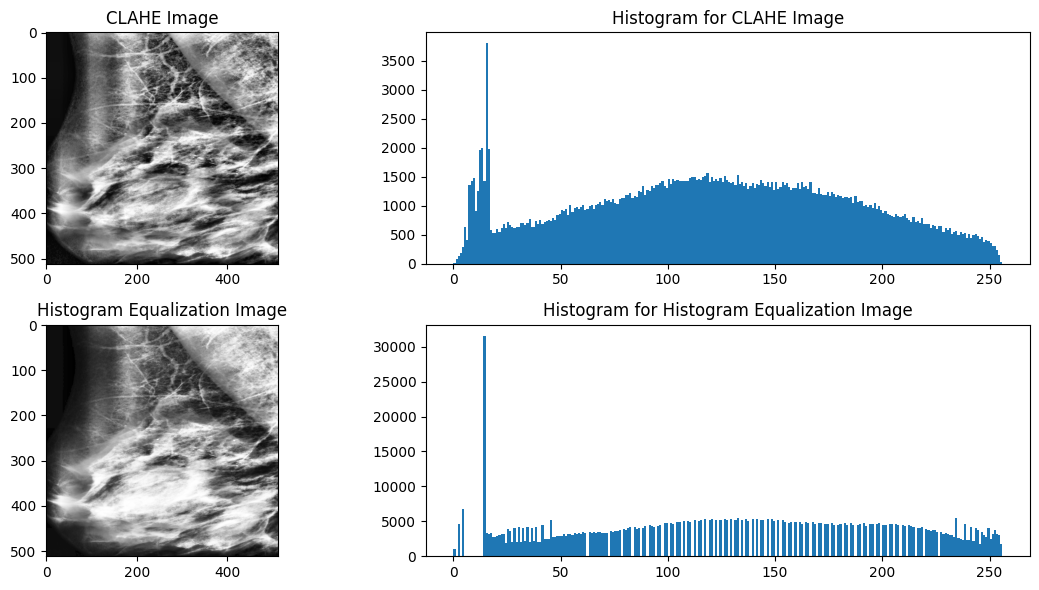

Contrast Improvement Index (CII) between CLAHE and HE images: 1.3185770877166896


In [ ]:

# Function to calculate Contrast Improvement Index (CII)
def calculate_cii(original_image, processed_image):
    # Calculate contrast values for original and processed images
    mean_gray_level_original = np.mean(original_image)
    contrast_original = np.var(original_image - mean_gray_level_original)

    mean_gray_level_processed = np.mean(processed_image)
    contrast_processed = np.var(processed_image - mean_gray_level_processed)

    # Calculate Contrast Improvement Index (CII)
    cii = contrast_processed / contrast_original
    return cii

# Function to display histograms for images
def display_histogram(image1, title1, image2, title2):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title(title1)
    plt.subplot(2, 2, 2)
    plt.hist(image1.ravel(), 256, [0, 256])
    plt.title('Histogram for ' + title1)

    plt.subplot(2, 2, 3)
    plt.imshow(image2, cmap='gray')
    plt.title(title2)
    plt.subplot(2, 2, 4)
    plt.hist(image2.ravel(), 256, [0, 256])
    plt.title('Histogram for ' + title2)

    plt.tight_layout()
    plt.show()

# Function for applying Contrast Limited Adaptive Histogram Equalization (CLAHE)
def apply_clahe(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray_img)
    return clahe_img

#Histogram Equalization (HE) on the image
def apply_histogram_equalization(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized_img = cv2.equalizeHist(gray_img)
    return cv2.cvtColor(equalized_img, cv2.COLOR_GRAY2BGR)

def preprocess_single_image_and_display(img_path, target_size=(256, 256)):
    img = cv2.imread(img_path)

    # Apply CLAHE
    clahe_img = apply_clahe(img)
    # Apply Histogram Equalization (HE)
    he_img = apply_histogram_equalization(img)

    # Display histograms for CLAHE and HE processed images
    display_histogram(clahe_img, 'CLAHE Image', he_img, 'Histogram Equalization Image')

    # Calculate CII for the processed images
    cii_value = calculate_cii(clahe_img, he_img)
    print("Contrast Improvement Index (CII) between CLAHE and HE images:", cii_value)

image_path_to_process = '/content/drive/MyDrive/mamo_images/mdb001.png'

preprocess_single_image_and_display(image_path_to_process)


In [ ]:
###################################################################################

# **CNN Model**

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from skimage.io import imread
from skimage.transform import resize

csv_path = 'labels.xlsx'
df = pd.read_excel(csv_path)

preprocessed_images_directory = '/content/drive/MyDrive/preprocessed_images'

target_size = (256, 256)

preprocessed_images = []
for idx in range(1, len(df) + 1):
    file_name = f"preprocessed_mdb{idx:03d}.png"  # format preprocessed_mdb00X.png
    img_path = os.path.join(preprocessed_images_directory, file_name)

    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
    else:
        img = imread(img_path, as_gray=True)  # Read image in grayscale
        img = resize(img, target_size)  # Resize image
        preprocessed_images.append(img)

# Convert lists to NumPy arrays
X = np.array(preprocessed_images)
y = df['Labels'].values

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Add the batch size dimension to the input data
X = X.reshape(-1, 256, 256, 1)  # adjust the channel dimension accordingly

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Data augmentation and normalization using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Batch size and image size
batch_size = 32

# Create data generators for training and validation
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size)

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))  # images are grayscale
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test.reshape((-1, 256, 256, 1)), y_test)
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test set
predictions = model.predict(X_test.reshape((-1, 256, 256, 1)))

# Optionally, you can use a threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)


3/3 [==============================] - 5s 980ms/step - loss: 1.6517 - accuracy: 0.6308
Test Accuracy: 0.6307692527770996
3/3 [==============================] - 2s 549ms/step
